In [1]:
# --- Standard Library ---
import sys
import os

project_root = '/d/hpc/projects/FRI/jf73497/aimi-project/src/segformer3duls/'
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import random
import yaml
from time import perf_counter

# --- Third-Party Libraries ---
import numpy as np
import torch
from tqdm import tqdm
from matplotlib import pyplot as plt
from termcolor import colored
from accelerate import Accelerator
from scipy.ndimage import (
    binary_closing,
    binary_opening,
    binary_dilation,
    binary_erosion,
    generate_binary_structure
)

# --- Local Imports ---
#sys.path.append("..")

from dataloaders.build_dataset import build_dataset, build_dataloader
from architectures.build_architecture import build_architecture
from metrics.competition_metric import ULS23_evaluator

# CSV paths are relative to the experiment directory, 
# so we change the working directory to the experiment directory.
os.chdir(project_root+"experiments/uls_2023/dice_oversampled_experiment/")



/d/hpc/projects/FRI/jf73497/aimi-project/src/segformer3duls/venv_segformer/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print(torch.cuda.is_available())

True


In [3]:
def test_time_dilation(input_tensor):
    # Convert to NumPy and squeeze batch and channel dimensions
    volume = input_tensor.squeeze().cpu().numpy()
    
    # Apply binary dilation
    dilated = binary_dilation(volume, structure=np.ones((3, 3, 3)))

    return dilated.astype(np.uint8)

def test_time_2xdilation(input_tensor):
    volume = input_tensor.squeeze().cpu().numpy()
    
    # Apply binary dilation twice
    dilated = binary_dilation(volume, structure=np.ones((3, 3, 3)))
    dilated = binary_dilation(dilated, structure=np.ones((3, 3, 3)))

    return dilated.astype(np.uint8)

def test_time_opening(input_tensor):
    volume = input_tensor.squeeze().cpu().numpy()
    
    # Apply binary opening: erosion followed by dilation
    opened = binary_erosion(volume, structure=np.ones((3, 3, 3)))
    opened = binary_dilation(opened, structure=np.ones((3, 3, 3)))

    return opened.astype(np.uint8)

def test_time_closing(input_tensor):
    volume = input_tensor.squeeze().cpu().numpy()
    
    # Apply binary closing: dilation followed by erosion
    closed = binary_dilation(volume, structure=np.ones((3, 3, 3)))
    closed = binary_erosion(closed, structure=np.ones((3, 3, 3)))

    return closed.astype(np.uint8)

def test_time_shift(model, input_tensor, threshold=0.5):
    predictions = []

    device = next(model.parameters()).device
    input_tensor = input_tensor.to(device)

    shifts = [
        (0, 0, 0),
        (5, 0, 0), 
        # (-5, 0, 0),
        # (0, 5, 0), 
        (0, -5, 0),
        # (0, 0, 5), 
        (0, 0, -5),
    ]

    with torch.no_grad():
        for dz, dx, dy in shifts:
            augmented = input_tensor.clone()

            # Shift
            augmented = torch.roll(augmented, shifts=(dz, dx, dy), dims=(2, 3, 4))

            # Model inference
            logits = model.forward(augmented)
            logits = logits[:, 1:, ...]
            pred = torch.sigmoid(logits[:, :, ...])
            pred = pred > 0.5

            # Undo shift
            pred = torch.roll(pred, shifts=(-dz, -dx, -dy), dims=(2, 3, 4))
            predictions.append(pred.float())

    avg_prediction = torch.stack(predictions).mean(dim=0, keepdims=True)

    # --- Morphological smoothing ---
    # Convert to NumPy for processing
    pred_np = avg_prediction.squeeze().cpu().numpy()

    # Binarize
    binary_pred = pred_np > threshold
    return binary_pred

In [15]:
evaluator = ULS23_evaluator()

def load_config(config_path: str):
    """loads the yaml config file

    Args:
        config_path (str): _description_

    Returns:
        Dict: _description_
    """
    with open(config_path, "r") as file:
        config = yaml.safe_load(file)
    return config

##################################################################################################
def seed_everything(config) -> None:
    seed = config["training_parameters"]["seed"]
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

 
def load_checkpoint(
        config: dict,
        accelerator,
):
    accelerator.load_state(
        config["training_parameters"]["load_checkpoint"]["load_checkpoint_path"]
    )
   

def _run_eval(accelerator, model, val_dataloader) -> None:
    """_summary_"""
    # Tell wandb to watch the model and optimizer values

    accelerator.print("[info] -- Starting model evaluation")

    # Initialize the training loss for the current Epoch
    original_dice_total = 0.0
    original_uls_metric_total = 0.0

    dilated_uls_metric_total = 0.0

    dilatedx2_uls_metric_total = 0.0

    opening_uls_metric_total = 0.0

    closing_uls_metric_total = 0.0

    shift_uls_metric_total = 0.0


    # set model to train mode
    model.eval()

    ULS_per_threshold = [0.0]*9
    thresholds = np.linspace(0.1, 0.9, 9)
    
    with torch.no_grad():
        for index, (raw_data) in enumerate(tqdm(val_dataloader)):
            # get data ex: (data, target)
            data, labels = (
                raw_data["image"],
                raw_data["label"],
            )

            logits = model.forward(data)
            logits = logits[:, 1:, ...]
            predicted = torch.sigmoid(logits)

            for i, threshold in enumerate(thresholds):
                y_pred = predicted > threshold
                y_true = labels[:, 1:, ...]

                ULS_per_threshold[i] += evaluator.ULS_score_metric(y_pred, y_true)

    ULS_per_threshold = np.array(ULS_per_threshold)/float(index + 1)
    best_index = np.argmax(ULS_per_threshold)
    best_threshold = thresholds[best_index]


    # set epoch to shift data order each epoch
    # self.val_dataloader.sampler.set_epoch(self.current_epoch)
    with torch.no_grad():
        for index, (raw_data) in enumerate(tqdm(val_dataloader)):
            # get data ex: (data, target)
            data, labels = (
                raw_data["image"],
                raw_data["label"],
            )

            logits = model.forward(data)
            logits = logits[:, 1:, ...]
            predicted = torch.sigmoid(logits)
            y_pred = predicted > best_threshold
            y_true = labels[:, 1:, ...]

            original_uls_metric_total += evaluator.ULS_score_metric(y_pred, y_true)
            # print(f"Orgi ULS: {original_uls_metric}")

            # Test-time dilation
            dilated_pred = test_time_dilation(y_pred.float())
            dilated_uls_metric_total += evaluator.ULS_score_metric(
                torch.tensor(dilated_pred).unsqueeze(0).unsqueeze(0).to(y_true.device),
                y_true,
            )

            # Test-time 2x dilation
            dilatedx2_pred = test_time_2xdilation(y_pred.float())
            dilatedx2_uls_metric_total += evaluator.ULS_score_metric(
                torch.tensor(dilatedx2_pred).unsqueeze(0).unsqueeze(0).to(y_true.device),
                y_true,
            )

            # Test-time opening
            opened_pred = test_time_opening(y_pred.float())
            opening_uls_metric_total += evaluator.ULS_score_metric(
                torch.tensor(opened_pred).unsqueeze(0).unsqueeze(0).to(y_true.device),
                y_true,
            )

            # Test-time closing
            closed_pred = test_time_closing(y_pred.float())
            closing_uls_metric_total += evaluator.ULS_score_metric(
                torch.tensor(closed_pred).unsqueeze(0).unsqueeze(0).to(y_true.device),
                y_true,
            )

            # Test-time shift
            shifted_pred = test_time_shift(model, data, threshold=best_threshold)
            shift_uls_metric_total += evaluator.ULS_score_metric(
                torch.tensor(shifted_pred).unsqueeze(0).unsqueeze(0).to(y_true.device),
                y_true,
            )


            # y_pred = test_time_augmentation(model, data, morph_op='opening')
            # my_uls_metric = evaluator.ULS_score_metric(y_pred, y_true)
            # print(f"My ULS: {my_uls_metric}")
            


            # # calculate metrics
            # if self.calculate_metrics:
            #     mean_dice, mean_uls_metric = self._calc_dice_metric(data, labels, use_ema)
            #     # keep track of number of total correct
            #     total_dice += mean_dice
            #     total_uls_metric += mean_uls_metric

            #     my_total_uls_metric += my_uls_metric

            # update loss for the current batch
            # epoch_avg_loss += loss.item()

    # Average across batches
    divisor = float(index + 1)
    original_uls_metric_total /= divisor
    dilated_uls_metric_total /= divisor
    dilatedx2_uls_metric_total /= divisor
    opening_uls_metric_total /= divisor
    closing_uls_metric_total /= divisor
    shift_uls_metric_total /= divisor


    # Print metrics
    accelerator.print(
        f"Original ULS: {colored(f'{original_uls_metric_total:.5f}', 'green')} | "
        f"Dilated: {colored(f'{dilated_uls_metric_total:.5f}', 'cyan')} | "
        f"2x Dilated: {colored(f'{dilatedx2_uls_metric_total:.5f}', 'cyan')} | "
        f"Opening: {colored(f'{opening_uls_metric_total:.5f}', 'cyan')} | "
        f"Closing: {colored(f'{closing_uls_metric_total:.5f}', 'cyan')} | "
        f"Shifted: {colored(f'{shift_uls_metric_total:.5f}', 'cyan')}"
    )

    return ULS_per_threshold



In [12]:
# load config
config = load_config("/d/hpc/home/jf73497/projects/aimi-project/src/evaluation_and_tta/config.yaml")

valset = build_dataset(
    dataset_type=config["dataset_parameters"]["dataset_type"],
    dataset_args=config["dataset_parameters"]["val_dataset_args"],
)
valloader = build_dataloader(
    dataset=valset,
    dataloader_args=config["dataset_parameters"]["val_dataloader_args"],
    config=config,
    train=False,
)
model = build_architecture(config)

Initializing dataset with csv file:  ../../../data/uls2023_seg_test/validation.csv
Number of samples:  1443
Loaded ULS2023 dataset


In [17]:
# load config
config = load_config("/d/hpc/home/jf73497/projects/aimi-project/src/evaluation_and_tta/config.yaml")

# set seed
seed_everything(config)

# build validation dataset & validataion data loader
valset = build_dataset(
    dataset_type=config["dataset_parameters"]["dataset_type"],
    dataset_args=config["dataset_parameters"]["val_dataset_args"],
)
valloader = build_dataloader(
    dataset=valset,
    dataloader_args=config["dataset_parameters"]["val_dataloader_args"],
    config=config,
    train=False,
)

# build the Model
model = build_architecture(config)


# use accelarate
accelerator = Accelerator(
    log_with="wandb",
    gradient_accumulation_steps=config["training_parameters"][
        "grad_accumulate_steps"
    ],
)

# convert all components to accelerate
model = accelerator.prepare_model(model=model)
valloader = accelerator.prepare_data_loader(data_loader=valloader)

if config["training_parameters"]["load_checkpoint"]["load_full_checkpoint"]:
        print("[info] -- Loading checkpoint.")
        load_checkpoint(
            config=config,
            accelerator=accelerator,)

print("[info] -- Running evaluation only.")
ULS_per_threshold = _run_eval(accelerator, model, valloader)

Initializing dataset with csv file:  ../../../data/uls2023_seg_test/validation.csv
Number of samples:  1443
Loaded ULS2023 dataset
[info] -- Loading checkpoint.
[info] -- Running evaluation only.
[info] -- Starting model evaluation


100%|██████████| 1443/1443 [30:47<00:00,  1.28s/it] 

Original ULS: 0.56390 | Dilated: 0.45920 | 2x Dilated: 0.35807 | Opening: 0.49852 | Closing: 0.56392 | Shifted: 0.50436


In [18]:
print(ULS_per_threshold)


[0.56390218 0.56372536 0.56326457 0.56277587 0.56233069 0.56185802
 0.56135509 0.56040147 0.55875401]


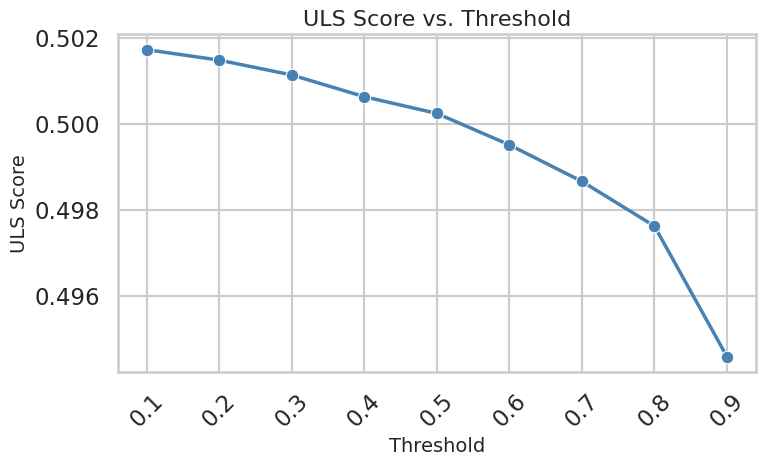

In [90]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example data (replace with your actual data)
thresholds = np.linspace(0.1, 0.9, 9)

# Set seaborn style
sns.set_theme(style="whitegrid", context="talk")

# Create the plot
plt.figure(figsize=(8, 5))
sns.lineplot(x=thresholds, y=ULS_per_threshold, marker="o", linewidth=2.5, color="steelblue")

# Labels and title
plt.xlabel("Threshold", fontsize=14)
plt.ylabel("ULS Score", fontsize=14)
plt.title("ULS Score vs. Threshold", fontsize=16)
plt.xticks(thresholds, rotation=45)
# plt.ylim(0, 1)
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.savefig("../../../../evaluation_and_tta/threshold_optimization_segformer_oversampled.pdf")
plt.show()

# Inference speed measurement

In [91]:
from time import perf_counter

def predict_with_threshold(model, data, threshold=0.5):

    """Predicts the segmentation mask using the model and applies a threshold.

    Args:
        model: The trained model for segmentation.
        data: Input data for prediction.
        threshold (float, optional): Threshold for binarizing predictions. Defaults to 0.5.

    Returns:
        torch.Tensor: Binarized predictions.
    """
    logits = model.forward(data)
    logits = logits[:, 1:, ...]  # Skip background class
    predicted = torch.sigmoid(logits)
    y_pred = predicted > threshold
    return y_pred.float()

time_data = {
    "segformer3d":{
        "dilation": [],
        "2xdilation": [],
        "opening": [],
        "closing": [],
        "shift": [],
        "original": [],
    }
}

# Best validation results for segformer3d
performance_data = {
    "segformer3d": {
        "dilation": 0.56112,
        "2xdilation": 0.35164,
        "opening": 0.48875,
        "closing": 0.56120,
        "shift": 0.53876,
        "original": 0.56112,
    }
}

def benchmark_inference_speed(model, val_dataloader) -> None:
    with torch.no_grad():

        warmup_iterations = 10
        for index, (raw_data) in enumerate(tqdm(val_dataloader)):
            # get data ex: (data, target)
            data, labels = (
                raw_data["image"],
                raw_data["label"],
            )

            _ = predict_with_threshold(model, data, threshold=0.5)

            if index >= warmup_iterations:
                break
        
        print("[info] -- Warmup completed. Starting inference speed measurement.")

        # After warmup, measure the inference speed
        measure_iterations = 100
        for index, (raw_data) in enumerate(tqdm(val_dataloader)):


            # Original prediction
            start_original = perf_counter()
            y_pred = predict_with_threshold(model, data, threshold=0.5)
            end_original = perf_counter()
            original_time = end_original - start_original
            time_data["segformer3d"]["original"].append(original_time)

            # Test-time dilation
            start_dilated = perf_counter()
            dilated_pred = test_time_dilation(predict_with_threshold(model, data, threshold=0.5))
            end_dilated = perf_counter()
            dilated_time = end_dilated - start_dilated
            time_data["segformer3d"]["dilation"].append(dilated_time)


            # Test-time 2x dilation
            start_dilatedx2 = perf_counter()
            dilatedx2_pred = test_time_2xdilation(predict_with_threshold(model, data, threshold=0.5))
            end_dilatedx2 = perf_counter()
            dilatedx2_time = end_dilatedx2 - start_dilatedx2
            time_data["segformer3d"]["2xdilation"].append(dilatedx2_time)

            # Test-time opening
            start_opened = perf_counter()
            opened_pred = test_time_opening(predict_with_threshold(model, data, threshold=0.5))
            end_opened = perf_counter()
            opened_time = end_opened - start_opened
            time_data["segformer3d"]["opening"].append(opened_time)

            # Test-time closing
            start_closed = perf_counter()
            closed_pred = test_time_closing(predict_with_threshold(model, data, threshold=0.5))
            end_closed = perf_counter()
            closed_time = end_closed - start_closed
            time_data["segformer3d"]["closing"].append(closed_time)

            # Test-time 
            start_shifted = perf_counter()
            shifted_pred = test_time_shift(model, data, threshold=0.5)
            end_shifted = perf_counter()
            shifted_time = end_shifted - start_shifted
            time_data["segformer3d"]["shift"].append(shifted_time)

            if index >= measure_iterations:
                break


benchmark_inference_speed(model, valloader)

# Average the times
avg_and_std_times = {key: [np.mean(times) if times else -1.0
                           , np.std(times) if times else -1.0] 
                     for key, times in time_data["segformer3d"].items()}




import pandas as pd

# Prepare data for DataFrame
rows = []
for method, times in time_data["segformer3d"].items():
    for t in times:
        rows.append({"Model": "segformer3d", "Method": method, "Time": t, "ULS": performance_data["segformer3d"][method]})

df_times = pd.DataFrame(rows)
csv_path = "../../../../evaluation_and_tta/inference_times.csv"
df_times.to_csv(csv_path, index=False)


  0%|          | 0/839 [00:00<?, ?it/s]

  1%|          | 10/839 [00:06<09:36,  1.44it/s]


[info] -- Warmup completed. Starting inference speed measurement.


 12%|█▏        | 100/839 [01:29<10:58,  1.12it/s]


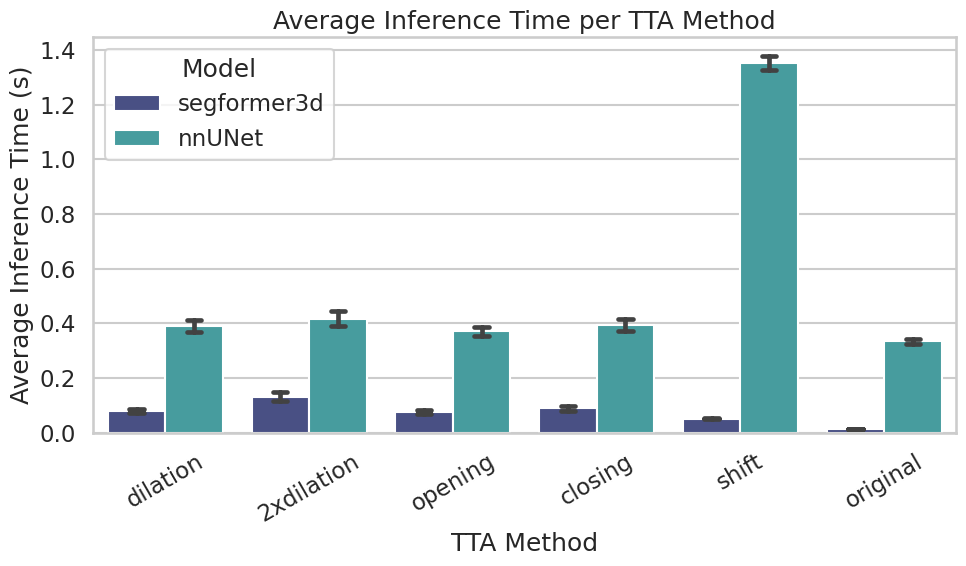

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
csv_path = "../../../../evaluation_and_tta/inference_times.csv"
df = pd.read_csv(csv_path)

# Plot grouped barplot
sns.set_theme(style="whitegrid", context="talk")
sns.set_palette("mako")
plt.figure(figsize=(10, 6))

ax = sns.barplot(
    df,
    x="Method",
    y="Time",
    errorbar="sd",
    capsize=0.2,
    palette="mako",
    hue="Model",
)

plt.ylabel("Average Inference Time (s)")
plt.xlabel("TTA Method")
plt.title("Average Inference Time per TTA Method")
plt.xticks(rotation=30)
plt.tight_layout()
plt.legend(title="Model")
plt.savefig("../../../../evaluation_and_tta/inference_times.pdf")
plt.show()

       Method        Model  avg_time  std_time      uls
0  2xdilation  segformer3d  0.132131  0.015267  0.35164
1     closing  segformer3d  0.089204  0.010283  0.56120
2    dilation  segformer3d  0.079967  0.008127  0.56112
3     opening  segformer3d  0.076444  0.008583  0.48875
4    original  segformer3d  0.013573  0.001521  0.56112
5       shift  segformer3d  0.051546  0.002451  0.53876


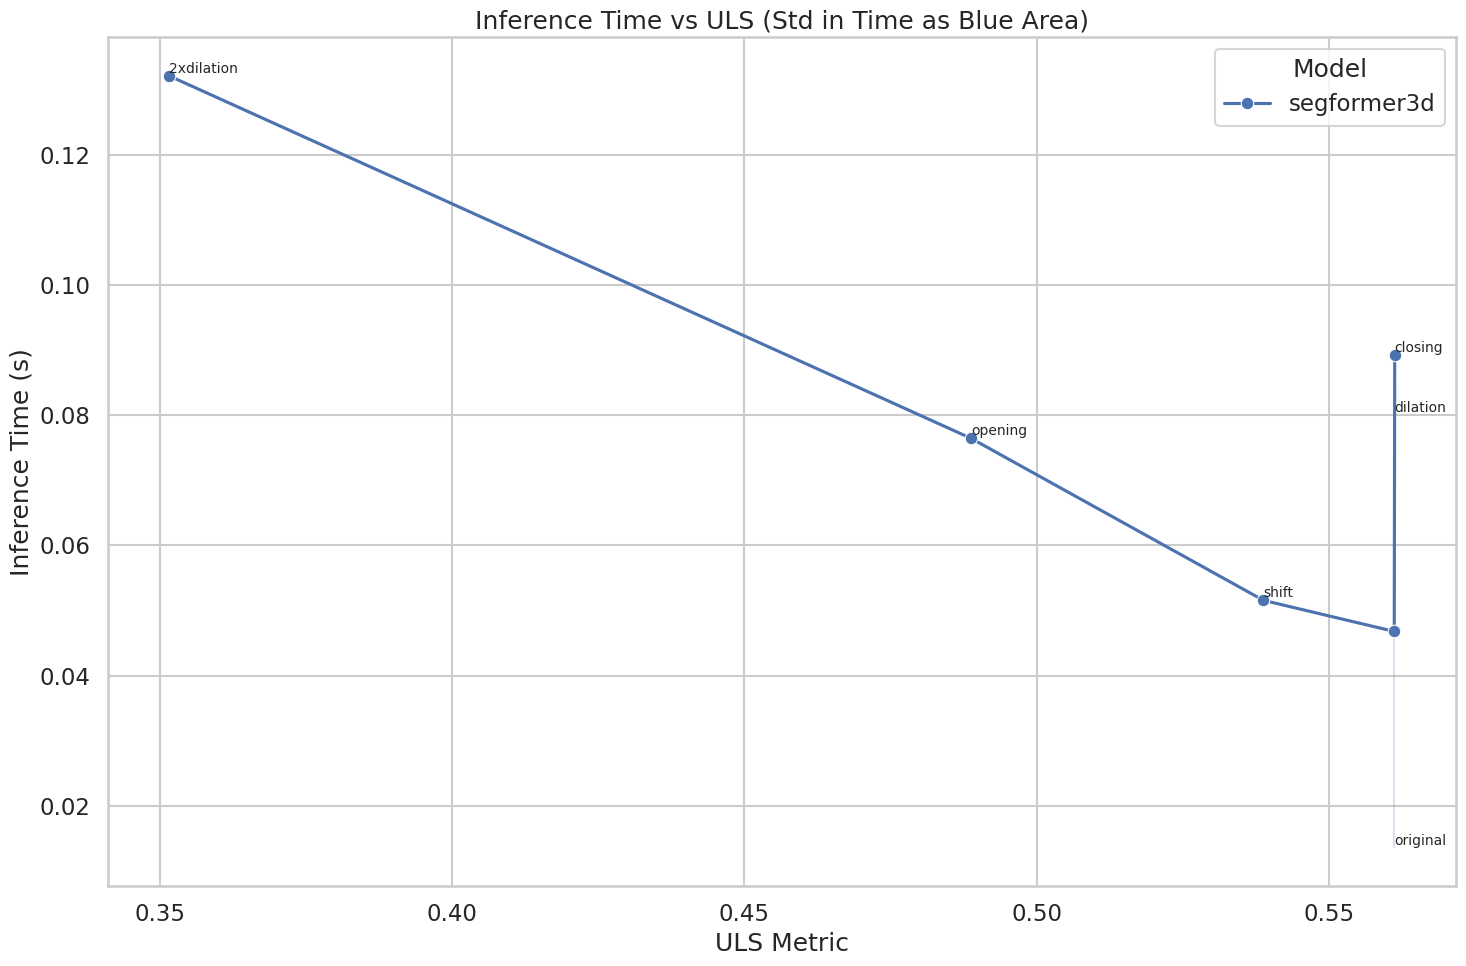

In [103]:
csv_path = "../../../../evaluation_and_tta/inference_times.csv"
df = pd.read_csv(csv_path)
df = df[df["Model"] == "segformer3d"]

# Group by Method and Model to get mean, std, and ULS
grouped = df.groupby(["Method", "Model"]).agg(
    avg_time=("Time", "mean"),
    std_time=("Time", "std"),
    uls=("ULS", "mean")
).reset_index()

print(grouped)

plt.figure(figsize=(15, 10))
sns.set_theme(style="whitegrid", context="talk")

for model, subdf in grouped.groupby("Model"):
    # Sort by ULS for a proper line plot
    subdf = subdf.sort_values("uls")
    # Plot the line (now x=ULS, y=avg_time)
    sns.lineplot(
        x=subdf["uls"],
        y=subdf["avg_time"],
        marker="o",
        label=model
    )

    # Add text labels for each method
    for i, row in subdf.iterrows():
        plt.text(
            row["uls"], row["avg_time"], row["Method"],
            fontsize=10, ha="left", va="bottom"
        )

plt.xlabel("ULS Metric")
plt.ylabel("Inference Time (s)")
plt.title("Inference Time vs ULS (Std in Time as Blue Area)")
plt.legend(title="Model")
plt.tight_layout()
plt.show()

# Model Size

In [62]:
def get_model_size(model):
    # Number of parameters
    num_params = sum(p.numel() for p in model.parameters())
    # Size in bytes (float32 = 4 bytes)
    param_size_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
    param_size_mb = param_size_bytes / (1024 ** 2)
    print(f"Model parameters: {num_params:,}")
    print(f"Model size (MB): {param_size_mb:.2f}")
    return num_params, param_size_mb

# Example usage:
num_params, mb = get_model_size(model)
print(f"Model type: {type(model)}")
print(f"Model parameters: {num_params:,}")
print(f"Model size (MB): {mb:.2f}")

Model parameters: 4,492,066
Model size (MB): 17.14
Model type: <class 'architectures.segformer3d.SegFormer3D'>
Model parameters: 4,492,066
Model size (MB): 17.14
